# Convolutional Neural Networks

## Write an algorithm for a dog-breed identification app 

---

In this notebook, we make the first steps towards developing an algorithm that could be used as part of a mobile or web app using deep learning concepts.  At the end of this project, we should be able to accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling. The image below displays potential sample output of the finished project. 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, we will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the convolutional neural net (CNN) that infers dog breed.  



### The Road Ahead

We break the notebook into separate steps:

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Setup working space & import datasets

The image data is comprised of 8351 dog images and 133 separate dog breed names. Additionally, one of the app requirements is to assign the most resembling dog breed to a given human face, therefore we also require a dataset with human faces. The dataset used are comprised by 13233 images from the labeled faces in the [wild dataset](http://vis-www.cs.umass.edu/lfw/). We ensure that we have downloaded the required human and dog datasets:


* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip). Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip). Unzip the folder and place it in the home directory, at location `/lfw`.  


In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [3]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("lfw/*/*"))
dog_files = np.array(glob("dogImages/*/*/*"))

# print number of images in each dataset
print('There are {} total human images.'.format(len(human_files)))
print('There are {} total dog images.'.format(len(dog_files)))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we need to detect human faces in images and to accomplish this we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) based on the [Haar-like features concept](https://en.wikipedia.org/wiki/Haar-like_feature). 

OpenCV provides many pre-trained face detectors, stored as XML files on [GitHub](https://github.com/opencv/opencv/tree/master/data/haarcascades). We have downloaded one of these detectors and stored it in the `/haarcascades` directory. In the next code cell, we demonstrate how to use this detector to find human faces in the first 5 sample images.

Number of faces detected in image 0:  1


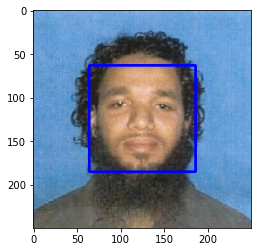

Number of faces detected in image 1:  1


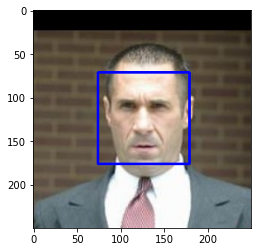

Number of faces detected in image 2:  1


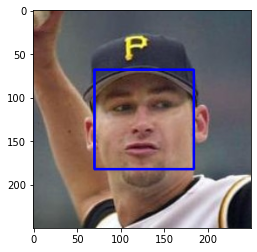

Number of faces detected in image 3:  1


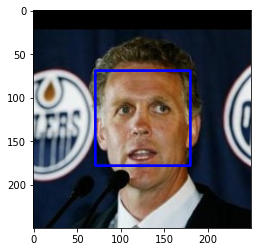

Number of faces detected in image 4:  1


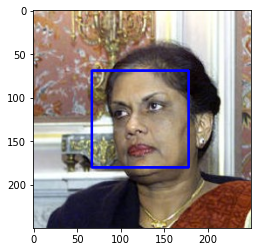

In [4]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

for idx, image in enumerate(human_files):
    while idx < 5:
        # load color (BGR) image
        img = cv2.imread(image)
        # convert BGR image to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # find faces in image
        faces = face_cascade.detectMultiScale(gray)

        # print number of faces detected in the image
        print('Number of faces detected in image {}: '.format(idx), len(faces))

        # get bounding box for each detected face
        for (x,y,w,h) in faces:
            # add bounding box to color image
            cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)

        # convert BGR image to RGB for plotting
        cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # display the image, along with bounding box
        plt.imshow(cv_rgb)
        plt.show()
        break
    

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that takes a string-valued file path to an image as input and returns `True` if a human face is detected in an image and `False` otherwise:

In [5]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### Assess the Human Face Detector

__Question 1:__ We use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  Indeed, the algorithm used falls short of this goal, but still gives acceptable performance. We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

- Actual humans classified as humans: 98.0 %
- Actual dogs classified as humans: 9.0 %

In [8]:
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [6]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

labelled_as_human = [face_detector(face) for face in tqdm(human_files_short, desc='Humans')]
print('Actual humans classified as humans: {} %'.format(sum(labelled_as_human) / len(human_files_short) * 100))

labelled_as_dog = [face_detector(face) for face in tqdm(dog_files_short, desc='Dogs')]
print('Actual dogs classified as humans: {} %'.format(sum(labelled_as_dog) / len(dog_files_short) * 100))

Humans: 100%|██████████| 100/100 [00:05<00:00, 17.51it/s]


Actual humans classified as humans: 98.0 %


Dogs: 100%|██████████| 100/100 [00:12<00:00,  8.13it/s]

Actual dogs classified as humans: 9.0 %


The face detector from OpenCV is probably one potential way to detect human images, but we will be exploring one more approach that makes use of deep learning.  We use the code cell below to design and test another face detection algorithm.  We report performance on `human_files_short` and `dog_files_short`.

An alternative would be to use the multi-task network from the “Multi-Task Cascaded Convolutional Neural Network” or MTCNN project, descibed in the [2016 paper](https://arxiv.org/abs/1604.02878). We can use a pre-trained model for face detection task specifically offered by [this implementation](https://github.com/ipazc/mtcnn) of the MTCNN architecture using TensorFlow and OpenCV. The motivation lies on the fact that it provides a top-performing pre-trained model and it can be easily installed as a library with `sudo pip install mtcnn`.

In [8]:
%pip install mtcnn
%pip install tensorflow

     |████████████████████████████████| 2.3 MB 29.6 MB/s eta 0:00:01
     |████████████████████████████████| 1.3 MB 82.4 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.
     |████████████████████▉           | 298.4 MB 163.1 MB/s eta 0:00:01

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 458.3 MB 24 kB/s 
     |████████████████████████████████| 5.6 MB 89.9 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 2.5 MB/s  eta 0:00:01
     |████████████████████████████████| 462 kB 125.3 MB/s eta 0:00:01
     |████████████████████████████████| 3.9 MB 100.0 MB/s eta 0:00:01
     |████████████████████████████████| 65 kB 9.1 MB/s s eta 0:00:01
     |████████████████████████████████| 131 kB 130.7 MB/s eta 0:00:01
     |████████████████████████████████| 781 kB 107.2 MB/s eta 0:00:01
     |████████████████████████████████| 152 kB 126.4 MB/s eta 0:00:01
     |████████████████████████████████| 97 kB 9.7 MB/s s eta 0:00:01
     |████████████████████████████████| 4.9 MB 106.6 MB/s eta 0:00:01
     |████████████████████████████████| 155 kB 125.9 MB/s eta 0:00:01
     |████████████████████████████████| 146 kB 130.4 MB/s eta 0:00:01
  Created wheel for clang: filename=clang-5.0-py3-none-any.whl size=30702 sha256=84d76a689761a500aa3d0c7274

Note: you may need to restart the kernel to use updated packages.


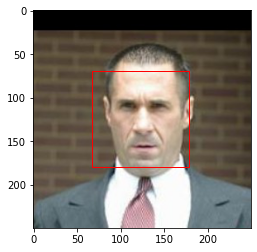

In [9]:
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from mtcnn.mtcnn import MTCNN
 
# draw an image with detected objects
def get_face_with_boxes(img_path, faces):
    # load the image
    img = pyplot.imread(img_path)
    # plot the image
    pyplot.imshow(img)
    # get the context for drawing boxes
    ax = pyplot.gca()
    # plot each box
    for face in faces:
        # create the shape
        rect = Rectangle((x, y), w, h, fill=False, color='red')
        # draw the box
        ax.add_patch(rect)
    # show the plot
    pyplot.show()
 
filename = human_files_short[1]
# load image from file
img = pyplot.imread(filename)
# create the detector, using default weights
detector = MTCNN()
# detect faces in the image
# faces = detector.detect_faces(img)
# display faces on the original image
get_face_with_boxes(filename, faces)


In [10]:
from mtcnn.mtcnn import MTCNN
import tensorflow as tf

# Following the above procedure we return "True" if face is detected in image stored at img_path
def mtcnn_face_detector(img_path):
    # img = cv2.imread(img_path)
    img = pyplot.imread(img_path)
    faces = detector.detect_faces(img)
    
    return len(faces) > 0

In [11]:
labelled_as_human = [mtcnn_face_detector(face) for face in tqdm(human_files_short, desc='Humans')]
print('Actual humans classified as humans: {} %'.format(sum(labelled_as_human) / len(human_files_short) * 100))

labelled_as_dog = [mtcnn_face_detector(face) for face in tqdm(dog_files_short, desc='Dogs')]
print('Actual dogs classified as humans: {} %'.format(sum(labelled_as_dog) / len(dog_files_short) * 100))

Humans:   0%|          | 0/100 [00:00<?, ?it/s]

Humans: 100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Actual humans classified as humans: 100.0 %


Dogs: 100%|██████████| 100/100 [00:45<00:00,  2.18it/s]

Actual dogs classified as humans: 15.0 %


### Assess the MTCNN Human Face Detector

__Question 2:__ 

Following a similar procedure, we used the code cell above to test the performance of the `mtcnn_face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

__Answer:__ 

- Actual humans classified as humans: 100.0 %
- Actual dogs classified as humans: 15.0 %

MTCNN implementation does better in the human detection task with 100 TP, however it produces 15 FP. Given that FPs increased from the previous assessment, we will opt for the OpenCV’s CascadeClassifier as it seems more reliable when it comes to non-human faces.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [13]:
%pip install torch
%pip install torchvision
%pip install keras

     |████████████▍                   | 320.8 MB 130.0 MB/s eta 0:00:04     |████████████                    | 313.8 MB 130.0 MB/s eta 0:00:04

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |███████████████████             | 494.1 MB 146.8 MB/s eta 0:00:03

     |███████████████████▎            | 500.9 MB 146.8 MB/s eta 0:00:03

     |███████████████████▌            | 507.8 MB 146.8 MB/s eta 0:00:03

     |███████████████████▉            | 514.8 MB 146.8 MB/s eta 0:00:03

     |████████████████████            | 521.8 MB 146.8 MB/s eta 0:00:03

     |████████████████████▍           | 528.7 MB 146.8 MB/s eta 0:00:03

     |████████████████████▋           | 535.7 MB 146.8 MB/s eta 0:00:03

     |████████████████████▉           | 542.7 MB 146.8 MB/s eta 0:00:02

     |█████████████████████▏          | 549.6 MB 148.0 MB/s eta 0:00:02

     |█████████████████████▍          | 556.6 MB 148.0 MB/s eta 0:00:02

     |█████████████████████▊          | 563.6 MB 148.0 MB/s eta 0:00:02

     |██████████████████████          | 570.6 MB 148.0 MB/s eta 0:00:02

     |██████████████████████▎         | 577.6 MB 148.0 MB/s eta 0:00:02

     |██████████████████████▌         | 584.7 MB 148.0 MB/s eta 0:00:02

     |██████████████████████▊         | 591.4 MB 148.0 MB/s eta 0:00:02

     |███████████████████████         | 598.5 MB 148.0 MB/s eta 0:00:02

     |███████████████████████▎        | 605.5 MB 148.0 MB/s eta 0:00:02

     |███████████████████████▋        | 612.4 MB 148.0 MB/s eta 0:00:02

     |███████████████████████▉        | 619.3 MB 148.0 MB/s eta 0:00:02

     |████████████████████████        | 626.3 MB 148.0 MB/s eta 0:00:02

     |████████████████████████▍       | 633.2 MB 148.0 MB/s eta 0:00:02

     |████████████████████████▋       | 640.1 MB 148.0 MB/s eta 0:00:02

     |█████████████████████████       | 647.1 MB 148.0 MB/s eta 0:00:02

     |█████████████████████████▏      | 654.2 MB 148.0 MB/s eta 0:00:02

     |█████████████████████████▌      | 661.3 MB 148.0 MB/s eta 0:00:02

     |█████████████████████████▊      | 668.4 MB 148.0 MB/s eta 0:00:02

     |██████████████████████████      | 676.0 MB 148.0 MB/s eta 0:00:02

     |██████████████████████████▎     | 683.8 MB 158.6 MB/s eta 0:00:01

     |██████████████████████████▋     | 691.7 MB 158.6 MB/s eta 0:00:01

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 831.4 MB 10 kB/s 
Note: you may need to restart the kernel to use updated packages.
     |████████████████████████████████| 22.1 MB 22.5 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [14]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/ec2-user/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### Making Predictions with the Pre-trained VGG-16 Model

In the next code cell, we write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Docs on how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [52]:
from PIL import Image
import torchvision.transforms as transforms

def image_to_tensor(img_path):
    img = Image.open(img_path).convert('RGB')
    
    transform = transforms.Compose([
        transforms.Resize(256), # resize the image to 256×256 pixels
        transforms.CenterCrop(224), # crop the image to 224×224 pixels about the center
        transforms.ToTensor(), # convert the image to PyTorch Tensor data type
        transforms.Normalize( # Normalize the image by setting its mean and standard deviation to the specified values
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )])

    # return a 4D Tensor
    img_t = transform(img)

    return img_t

def VGG16_predict(img_path):
    """
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path 
    Args:
        img_path: path to an image
    Returns:
        Index corresponding to VGG-16 model's prediction
    """
    
    # Load and pre-process the image from the given img_path
    tensor = image_to_tensor(img_path)

    # Prepare a batch to be passed through the network
    batch_t = torch.unsqueeze(tensor, 0)
    
    # Move tensor to GPU if available
    if use_cuda:
        batch_t = batch_t.cuda()
    
    # Turn on evaluation mode
    VGG16.eval()
    
    # Carry out inference
    out = VGG16(batch_t)

    # Return the *index* of the predicted class for that image
    result = torch.argmax(out).item()
    
    return result # predicted class index

In [16]:
# using the above function directly we expect to get 
# an index value between 151 and 268 (inclusive) indicating a dog breed 
VGG16_predict(dog_files_short[1])

196

### Write the Dog Detector based on the VGG-16 model
While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only to check if the pre-trained model predicts an index between 151 and 268 (inclusive).

In [17]:
# returns "True" if a dog is detected in the image stored at img_path
def VGG16_dog_detector(img_path):
    predicted_class_idx = VGG16_predict(img_path)
    return 151 <= predicted_class_idx <= 268

### Assess the Dog Detector

__Question 3:__ Testing the performance of the `VGG16_dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

- Actual dogs classified as humans: 1.0 %
- Actual dogs classified as dogs: 99.0 %

In [18]:
# test the performance of the dog_detector function
# on the images in human_files_short and dog_files_short

dog_in_humans = [VGG16_dog_detector(img) for img in tqdm(human_files_short, desc='Humans')]
print('Actual dogs classified as humans: {} %'.format(sum(dog_in_humans) / len(dog_files_short) * 100))

dog_in_dogs = [VGG16_dog_detector(img) for img in tqdm(dog_files_short, desc='Dogs')]
print('Actual dogs classified as dogs: {} %'.format(sum(dog_in_dogs) / len(human_files_short) * 100))

Humans: 100%|██████████| 100/100 [00:04<00:00, 20.54it/s]


Actual dogs classified as humans: 1.0 %


Dogs: 100%|██████████| 100/100 [00:05<00:00, 16.84it/s]

Actual dogs classified as dogs: 99.0 %


VGG-16 as a potential network to detect dog images in the algorithm looks as a fair choice, but we also employ [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3) pre-trained model.  We obtain the model and report performance on the same `human_files_short` and `dog_files_short` files.

### Obtain Pre-trained ResNet-50 Model

For this task we employ the Keras API to load the ResNet-50 convolutional neural network and run images through it. This model is trained on the vast image database of ImageNet. For each image out of the total 1000 categories the model assigns probabilites and a positive dog detection to an image is attributed, if the model assigns the max probability to one of the 118 dog related categories.

In [19]:
%pip install keras

Note: you may need to restart the kernel to use updated packages.


In [20]:
from keras.applications.resnet import ResNet50

from keras.preprocessing import image
from keras.applications.resnet import preprocess_input, decode_predictions

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

102981632/102967424 [==============================] - 1s 0us/step


### Making Predictions with the Pre-trained ResNet-50 Model

Below we follow a similar approach for pre-processing images and predicting the corresponding class.

In [21]:
# preprocessing images
def image_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)


def ResNet50_predict(img_path):
    """
    Use pre-trained ResNet50 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path 
    Args:
        img_path: path to an image
    Returns:
        Index corresponding to ResNet50 model's prediction
    """
    
    # parameterise image
    img = preprocess_input(image_to_tensor(img_path))
    
    # get vector for given image at img_path
    result = np.argmax(ResNet50_model.predict(img))
    
    return result

### Write and assess the Dog Detector based on the ResNet-50 Model

In [22]:
# returns "True" if a dog is detected in the image stored at img_path
def ResNet50_dog_detector(img_path):
    predicted_class_idx = ResNet50_predict(img_path)
    return 151 <= predicted_class_idx <= 268

__Question 4:__ Testing the performance of the `ResNet50_dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

- Actual dogs classified as humans: 4 %
- Actual dogs classified as dogs: 100 %

In [23]:
# test the performance of the ResNet50_dog_detector function on the same images as earlier 

dog_in_humans = [ResNet50_dog_detector(img) for img in tqdm(human_files_short, desc='Humans')]
print('Actual dogs classified as humans: {} %'.format(sum(dog_in_humans) / len(dog_files_short) * 100))

dog_in_dogs = [ResNet50_dog_detector(img) for img in tqdm(dog_files_short, desc='Dogs')]
print('Actual dogs classified as dogs: {} %'.format(sum(dog_in_dogs) / len(human_files_short) * 100))

Humans: 100%|██████████| 100/100 [00:06<00:00, 15.14it/s]


Actual dogs classified as humans: 4.0 %


Dogs: 100%|██████████| 100/100 [00:06<00:00, 15.07it/s]

Actual dogs classified as dogs: 100.0 %


Although RestNet-50 implementation did a slightly better job in the dog detection task, it produced more FPs than the VGG-16 model. 

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, we create a CNN that classifies dog breeds. We should create a CNN _from scratch_, and attain a test accuracy of at least 10%.  In Step 4 of this notebook, we will use transfer learning to create a CNN that attains greatly improved accuracy. Using CNNs for image analysis as opposed to other neural network types is due to their advantage of translating invariance and their shared weights with their architecture involving multiple hidden layers  which perform mathematical convolution operations on the input layer.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpeg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpeg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpeg" width="200"> | <img src="images/American_water_spaniel_00648.jpeg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  This vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpeg" width="150"> | <img src="images/Labrador_retriever_06455.jpeg" width="240"> | <img src="images/Labrador_retriever_06449.jpeg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Considering that practice is far ahead of the theory in deep learning we aim to experiment with different architectures.

### Specify Data Loaders for the Dog Dataset

Below we write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively). We also use [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) as a resource.  

In [26]:
import os
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Write data loaders for training, validation, and test sets
data_dir = 'dogImages/'
train_location = os.path.join(data_dir, 'train/')
validation_location = os.path.join(data_dir, 'valid/')
test_location = os.path.join(data_dir, 'test/')

# Specify normalization values as earlier
normalization = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

# Define a dictionary with appropriate transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(15),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalization]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalization]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalization])
}

batch_size = 64

# Load image datasets as tensors
train_data = ImageFolder(train_location, transform=data_transforms['train'])
validation_data = ImageFolder(validation_location, transform=data_transforms['valid'])
test_data = ImageFolder(test_location, transform=data_transforms['test'])

# Define instances for DataLoaders
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(validation_data, batch_size=batch_size, shuffle=True)

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:

To compare performance with transfer learning models, we apply in all sets the same normalisation step as the one used for ImageNet datasets.

For training data, a `RandomRotation` of 15 degrees as changing the angle wouldn't affect what's displayed as dog breed.
`RandomResizedCrop` & `RandomHorizontalFlip` augmentation techniques are applied only to the training data since with image augmentation we extend the dataset by introducing randomness, thus improving generalization during training time and we possibly prevent overfitting. 
`RandomResizedCrop` is used because the model should learn more and more data in different orientations and size is 224 to compare results with tranfer learning models. Similarly, `RandomHorizontalFlip` makes sense to use as opposed to vertical flip as we wouldn't expect images of dogs flipped upside down. 

For validation and test data we don't apply random transforms because we should be able to compare model performance in different iterations so a resize of 256, followed by a center crop of 224 are used in both datasets.

### Model Architecture 

In this section we first define X network architectures and then assess the performance of each one seperately. 

In [27]:
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim 
from torch.autograd import Variable

num_classes = 133 # total classes of dog breeds

### 1. Basic architecture (VGG based)

In [28]:
# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        
        self.cnn_layers = nn.Sequential(
            # Defining a 2D convolution layer
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),   # input: 3x224x224, output: 16x224x224
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),                  # input: 16x224x224, output: 16x112x112
            
            # Defining another 2D convolution layer
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # input: 16x112x112, output: 32x112x112
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),                  # input: 32x112x112, output: 32x56x56
            
            # Defining the third 2D convolution layer
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # input: 32x56x56, output: 64x56x56
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),                  # input: 64x56x56, output: 64x28x28
            
            # Defining the fourth 2D convolution layer
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), # input: 64x28x28, output: 128x28x28
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),                  # input: 128x28x28, output: 128x14x14
            
            # Defining the final 2D convolution layer
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),# input: 128x14x14, output: 256x14x14
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),                  # input: 256x14x14, output: 256x7x7
            nn.Dropout(0.25)

        )
        
        
        self.fully_connected_layers = nn.Sequential(
            nn.Linear(in_features=256*7*7, out_features=1024),      # Linear layer 128x14x14 --> 1024
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(in_features=1024, out_features=num_classes)   # Linear layer 1024 --> 133
        )
    
    def forward(self, x):
        ## Define forward behaviour of the data
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fully_connected_layers(x)
            
        return x

### 2. Basic architecture (VGG based) with batch normalisation

In [73]:
class Net_batch_norm(nn.Module):
    def __init__(self):
        super(Net_batch_norm, self).__init__()        
        self.cnn_layers = nn.Sequential(
            # Defining a 2D convolution layer
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),  
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),                 
            nn.BatchNorm2d(16),
            
            # Defining another 2D convolution layer
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),                 
            nn.BatchNorm2d(32),
            
            # Defining the third 2D convolution layer
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),                 
            nn.BatchNorm2d(64),
            
            # Defining the fourth 2D convolution layer
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),                 
            nn.BatchNorm2d(128),
            
            # Defining the final 2D convolution layer
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),                  
            nn.BatchNorm2d(256)

        )
                
        self.fully_connected_layers = nn.Sequential(
            nn.Linear(in_features=256*7*7, out_features=1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(p=0.25),
            nn.Linear(in_features=1024, out_features=num_classes)
        )
    
    def forward(self, x):
        ## Define forward behaviour of the data
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fully_connected_layers(x)
            
        return x

### 3. Basic architecture (VGG based) with batch normalisation and adaptive average pooling

In [75]:
class Net_batch_norm_aap(nn.Module):
    def __init__(self):
        super(Net_batch_norm_aap, self).__init__()        
        self.cnn_layers = nn.Sequential(
            # Defining a 2D convolution layer
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),  
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),                 
            nn.BatchNorm2d(16),
            
            # Defining another 2D convolution layer
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),                 
            nn.BatchNorm2d(32),
            
            # Defining the third 2D convolution layer
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),                 
            nn.BatchNorm2d(64),
            
            # Defining the fourth 2D convolution layer
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),                 
            nn.BatchNorm2d(128),
            
            # Defining the final 2D convolution layer
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1), # input: 128x14x14, output: 256x14x14
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),                   # input: 256x14x14, output: 256x7x7  
            nn.BatchNorm2d(256),
            nn.AdaptiveAvgPool2d(1)                                  # input: 256x7x7, output: 256x1x1
     
        )
                
        self.fully_connected_layers = nn.Sequential(
            nn.Linear(in_features=256, out_features=num_classes),
            nn.ReLU(),
            # nn.BatchNorm1d(1024),
            # nn.Dropout(p=0.25),
            # nn.Linear(in_features=1024, out_features=num_classes)
        )
    
    def forward(self, x):
        ## Define forward behaviour of the data
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fully_connected_layers(x)
            
        return x

### 4. Deep architecture (VGG based) with batch normalisation and adaptive average pooling

In [86]:
class Net_batch_norm_aap_deep(nn.Module):
    def __init__(self):
        super(Net_batch_norm_aap_deep, self).__init__()        
        self.cnn_layers = nn.Sequential(
            # Defining a 2D convolution layer
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),  
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),                 
            nn.BatchNorm2d(16),
            
            # Defining another 2D convolution layer
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),                 
            nn.BatchNorm2d(32),
            
            # Defining the third 2D convolution layer
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),                 
            nn.BatchNorm2d(64),
            
            # Defining the fourth 2D convolution layer
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),                 
            nn.BatchNorm2d(128),
            
            # Defining the fifth 2D convolution layer
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),                     
            nn.BatchNorm2d(256),            
            
            # Defining a sixth 2D convolution layer
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1), # input: 256x7x7, output: 512x7x7
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
            nn.AdaptiveAvgPool2d(1)                                  # input: 512x7x7, output: 512x1x1

        )
                
        self.fully_connected_layers = nn.Sequential(
            nn.Linear(in_features=512, out_features=num_classes)
            # nn.ReLU(),
            # nn.BatchNorm1d(1024),
            # nn.Linear(in_features=1024, out_features=num_classes)
        )
    
    def forward(self, x):
        ## Define forward behaviour of the data
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fully_connected_layers(x)
            
        return x

### Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [29]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [30]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    train_loss_list = []
    valid_loss_list = []
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation correct and loss
        train_loss = 0.0
        train_correct = 0.0
        train_total = 0.0
        
        valid_loss = 0.0
        valid_correct = 0.0
        valid_total = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            # clear gradients of all optimized variables
            optimizer.zero_grad()

            # forwarward pass
            output = model(data)
            
            # calculate batch loss
            loss = criterion(output, target)
            
            # backward pass
            loss.backward()
            
            # perform optimization step (parameter update)
            optimizer.step()
            
            # update training loss
            train_loss += ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            # train_loss += loss.item()*data.size(0)            
            
            # convert output to a predicted class
            pred = output.data.max(1, keepdim=True)[1]
            
            # compare the predictions to true labels
            train_correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            train_total += data.size(0)
        
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
#             with torch.no_grad():
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
                
            # calculate the batch loss
            loss = criterion(output, target)
            
            # update total validation loss
            valid_loss += ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            # valid_loss += loss.item()*data.size(0)
            
            # convert output to a predicted class
            pred = output.data.max(1, keepdim=True)[1]
            
            # compare the predictions to true labels
            valid_correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            valid_total += data.size(0)
            
        # calculate average losses
        train_loss = train_loss/len(loaders['train'].dataset)
        valid_loss = valid_loss/len(loaders['valid'].dataset)
        
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        # save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model...'.format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
        train_loss_list.append(train_loss)
        valid_loss_list.append(valid_loss)
            
    # return trained model
    return model, train_loss_list, valid_loss_list

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [31]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        
        # 1 output
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        
        # convert output probabilities to predicted class
        # 2 output defined
        output = F.softmax(output, dim=1)
        pred = output.data.max(1, keepdim=True)[1]
                           
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))  
    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (100. * correct / total, correct, total))

### Train, validate and test models defined earlier

Also specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

### 1. Basic architecture (VGG based) tryout

In [71]:
import torch.optim as optim

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

# define loaders_scratch
loaders_scratch = {'train': train_dataloader,
                   'valid': valid_dataloader,
                   'test': test_dataloader}

# specify Loss Function and Optimizer
criterion_scratch = nn.CrossEntropyLoss()

# select optimizer
optimizer_scratch = optim.Adam(model_scratch.parameters(), lr=0.001)

# train the model
model_scratch, train_loss_list_scratch, valid_loss_list_scratch = train(
    50, loaders_scratch, model_scratch, optimizer_scratch, criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

# test the model    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Epoch: 1 	Training Loss: 4.885160 	Validation Loss: 4.860640
Validation loss decreased (inf --> 4.860640). Saving model...
Epoch: 2 	Training Loss: 4.796704 	Validation Loss: 4.675258
Validation loss decreased (4.860640 --> 4.675258). Saving model...
Epoch: 3 	Training Loss: 4.664010 	Validation Loss: 4.471983
Validation loss decreased (4.675258 --> 4.471983). Saving model...
Epoch: 4 	Training Loss: 4.509978 	Validation Loss: 4.363282
Validation loss decreased (4.471983 --> 4.363282). Saving model...
Epoch: 5 	Training Loss: 4.401618 	Validation Loss: 4.168793
Validation loss decreased (4.363282 --> 4.168793). Saving model...
Epoch: 6 	Training Loss: 4.313690 	Validation Loss: 4.082218
Validation loss decreased (4.168793 --> 4.082218). Saving model...
Epoch: 7 	Training Loss: 4.186513 	Validation Loss: 3.999390
Validation loss decreased (4.082218 --> 3.999390). Saving model...
Epoch: 8 	Training Loss: 4.100632 	Validation Loss: 3.878602
Validation loss decreased (3.999390 --> 3.878602

### 2. Basic architecture (VGG based) with batch normalisation tryout

In [ ]:
import torch.optim as optim

# instantiate the CNN
model_batch_norm = Net_batch_norm()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_batch_norm.cuda()

# define loaders_scratch
loaders_scratch = {'train': train_dataloader,
                   'valid': valid_dataloader,
                   'test': test_dataloader}

# specify Loss Function and Optimizer
criterion_model_batch_norm = nn.CrossEntropyLoss()

# select optimizer
optimizer_model_batch_norm = optim.Adam(model_batch_norm.parameters(), lr=0.001)

# train the model
model_batch_norm, train_loss_list_batch_norm, valid_loss_batch_norm = train(
    50, 
    loaders_scratch,
    model_batch_norm,
    optimizer_model_batch_norm,
    criterion_model_batch_norm,
    use_cuda,
    'model_batch_norm.pt')

# load the model that got the best validation accuracy
model_batch_norm.load_state_dict(torch.load('model_batch_norm.pt'))

# test the model    
test(loaders_scratch, model_batch_norm, criterion_model_batch_norm, use_cuda)

Epoch: 1 	Training Loss: 4.857297 	Validation Loss: 4.827427
Validation loss decreased (inf --> 4.827427). Saving model...
Epoch: 2 	Training Loss: 4.473129 	Validation Loss: 4.428398
Validation loss decreased (4.827427 --> 4.428398). Saving model...
Epoch: 3 	Training Loss: 4.272707 	Validation Loss: 4.079905
Validation loss decreased (4.428398 --> 4.079905). Saving model...
Epoch: 4 	Training Loss: 4.104670 	Validation Loss: 3.894193
Validation loss decreased (4.079905 --> 3.894193). Saving model...
Epoch: 5 	Training Loss: 3.905390 	Validation Loss: 3.915130
Epoch: 6 	Training Loss: 3.749925 	Validation Loss: 3.619932
Validation loss decreased (3.894193 --> 3.619932). Saving model...
Epoch: 7 	Training Loss: 3.612126 	Validation Loss: 3.674235
Epoch: 8 	Training Loss: 3.510414 	Validation Loss: 3.343713
Validation loss decreased (3.619932 --> 3.343713). Saving model...
Epoch: 9 	Training Loss: 3.362459 	Validation Loss: 3.340982
Validation loss decreased (3.343713 --> 3.340982). Sav

### 3. Basic architecture (VGG based) with batch normalisation and adaptive average pooling tryout

In [76]:
import torch.optim as optim

# instantiate the CNN
model_batch_norm_aap = Net_batch_norm_aap()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_batch_norm_aap.cuda()

# define loaders_scratch
loaders_scratch = {'train': train_dataloader,
                   'valid': valid_dataloader,
                   'test': test_dataloader}

# specify Loss Function and Optimizer
criterion_model_batch_norm_aap = nn.CrossEntropyLoss()

# select optimizer
optimizer_model_batch_norm_aap = optim.Adam(model_batch_norm_aap.parameters(), lr=0.001)

# train the model
model_batch_norm_aap, train_loss_list_batch_norm_aap, valid_loss_batch_norm_aap = train(
    50, 
    loaders_scratch,
    model_batch_norm_aap,
    optimizer_model_batch_norm_aap,
    criterion_model_batch_norm_aap,
    use_cuda,
    'model_batch_norm_aap.pt')

# load the model that got the best validation accuracy
model_batch_norm_aap.load_state_dict(torch.load('model_batch_norm_aap.pt'))

# test the model    
test(loaders_scratch, model_batch_norm_aap, criterion_model_batch_norm_aap, use_cuda)

Epoch: 1 	Training Loss: 4.718786 	Validation Loss: 4.578437
Validation loss decreased (inf --> 4.578437). Saving model...
Epoch: 2 	Training Loss: 4.479388 	Validation Loss: 4.355754
Validation loss decreased (4.578437 --> 4.355754). Saving model...
Epoch: 3 	Training Loss: 4.285013 	Validation Loss: 4.216361
Validation loss decreased (4.355754 --> 4.216361). Saving model...
Epoch: 4 	Training Loss: 4.132131 	Validation Loss: 4.034370
Validation loss decreased (4.216361 --> 4.034370). Saving model...
Epoch: 5 	Training Loss: 3.975180 	Validation Loss: 3.858827
Validation loss decreased (4.034370 --> 3.858827). Saving model...
Epoch: 6 	Training Loss: 3.836849 	Validation Loss: 3.731294
Validation loss decreased (3.858827 --> 3.731294). Saving model...
Epoch: 7 	Training Loss: 3.694479 	Validation Loss: 3.971262
Epoch: 8 	Training Loss: 3.560717 	Validation Loss: 3.339855
Validation loss decreased (3.731294 --> 3.339855). Saving model...
Epoch: 9 	Training Loss: 3.446823 	Validation Lo

### 4. Deeper architecture (VGG based) with batch normalisation and adaptive average pooling tryout

In [81]:
import torch.optim as optim

# instantiate the CNN
model_batch_norm_aap_deep = Net_batch_norm_aap_deep()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_batch_norm_aap_deep.cuda()

# define loaders_scratch
loaders_scratch = {'train': train_dataloader,
                   'valid': valid_dataloader,
                   'test': test_dataloader}

# specify Loss Function and Optimizer
criterion_model_batch_norm_aap_deep = nn.CrossEntropyLoss()

# select optimizer
optimizer_model_batch_norm_aap_deep = optim.Adam(model_batch_norm_aap_deep.parameters(), lr=0.001)

# train the model
model_batch_norm_aap_deep, train_loss_list_batch_norm_aap_deep, valid_loss_batch_norm_aap_deep = train(
    50, 
    loaders_scratch,
    model_batch_norm_aap_deep,
    optimizer_model_batch_norm_aap_deep,
    criterion_model_batch_norm_aap_deep,
    use_cuda,
    'model_batch_norm_aap_deep.pt')

# load the model that got the best validation accuracy
model_batch_norm_aap_deep.load_state_dict(torch.load('model_batch_norm_aap_deep.pt'))

# test the model    
test(loaders_scratch, model_batch_norm_aap_deep, criterion_model_batch_norm_aap_deep, use_cuda)

Epoch: 1 	Training Loss: 4.747022 	Validation Loss: 4.540272
Validation loss decreased (inf --> 4.540272). Saving model...
Epoch: 2 	Training Loss: 4.453910 	Validation Loss: 4.288507
Validation loss decreased (4.540272 --> 4.288507). Saving model...
Epoch: 3 	Training Loss: 4.226117 	Validation Loss: 4.140059
Validation loss decreased (4.288507 --> 4.140059). Saving model...
Epoch: 4 	Training Loss: 4.054228 	Validation Loss: 3.997298
Validation loss decreased (4.140059 --> 3.997298). Saving model...
Epoch: 5 	Training Loss: 3.868289 	Validation Loss: 3.754089
Validation loss decreased (3.997298 --> 3.754089). Saving model...
Epoch: 6 	Training Loss: 3.736993 	Validation Loss: 3.842653
Epoch: 7 	Training Loss: 3.574007 	Validation Loss: 3.423040
Validation loss decreased (3.754089 --> 3.423040). Saving model...
Epoch: 8 	Training Loss: 3.421843 	Validation Loss: 3.210023
Validation loss decreased (3.423040 --> 3.210023). Saving model...
Epoch: 9 	Training Loss: 3.293439 	Validation Lo

In [87]:
import torch.optim as optim

# instantiate the CNN
model_batch_norm_aap_deep_no_relu = Net_batch_norm_aap_deep()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_batch_norm_aap_deep_no_relu.cuda()

# define loaders_scratch
loaders_scratch = {'train': train_dataloader,
                   'valid': valid_dataloader,
                   'test': test_dataloader}

# specify Loss Function and Optimizer
criterion_model_batch_norm_aap_deep_no_relu = nn.CrossEntropyLoss()

# select optimizer
optimizer_model_batch_norm_aap_deep_no_relu = optim.Adam(model_batch_norm_aap_deep_no_relu.parameters(), lr=0.001)

# train the model
model_batch_norm_aap_deep_no_relu, train_loss_list_batch_norm_aap_deep_no_relu, valid_loss_batch_norm_aap_deep_no_relu = train(
    50, 
    loaders_scratch,
    model_batch_norm_aap_deep_no_relu,
    optimizer_model_batch_norm_aap_deep_no_relu,
    criterion_model_batch_norm_aap_deep_no_relu,
    use_cuda,
    'model_batch_norm_aap_deep_no_relu.pt')

# load the model that got the best validation accuracy
model_batch_norm_aap_deep_no_relu.load_state_dict(torch.load('model_batch_norm_aap_deep_no_relu.pt'))

# test the model    
test(loaders_scratch, model_batch_norm_aap_deep_no_relu, criterion_model_batch_norm_aap_deep_no_relu, use_cuda)

Epoch: 1 	Training Loss: 4.655778 	Validation Loss: 4.433819
Validation loss decreased (inf --> 4.433819). Saving model...
Epoch: 2 	Training Loss: 4.339648 	Validation Loss: 4.197802
Validation loss decreased (4.433819 --> 4.197802). Saving model...
Epoch: 3 	Training Loss: 4.100067 	Validation Loss: 3.946599
Validation loss decreased (4.197802 --> 3.946599). Saving model...
Epoch: 4 	Training Loss: 3.914328 	Validation Loss: 3.784235
Validation loss decreased (3.946599 --> 3.784235). Saving model...
Epoch: 5 	Training Loss: 3.733835 	Validation Loss: 3.536033
Validation loss decreased (3.784235 --> 3.536033). Saving model...
Epoch: 6 	Training Loss: 3.531478 	Validation Loss: 3.349866
Validation loss decreased (3.536033 --> 3.349866). Saving model...
Epoch: 7 	Training Loss: 3.384254 	Validation Loss: 3.241125
Validation loss decreased (3.349866 --> 3.241125). Saving model...
Epoch: 8 	Training Loss: 3.233719 	Validation Loss: 2.929706
Validation loss decreased (3.241125 --> 2.929706

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 


#### Basic architecture (VGG based) 

We implement a simple baseline architecture with five convolutional layers to extract features from the images with ReLU activation function. Each convolutional layer has a kernel size of 3x3, a padding of 1 and a stride of 1 which gradually increases the number of feature maps from 3 to 256, but keeps the same size.

We also apply max pooling layers (takes maximum from a feature map) with a 2x2 kernel and a stride of 2, that cuts the size of all feature maps by half to progressively reduce the number of learnable parameters (decreasing the size of the output) from one layer to the next, but still with an increasing depth. 

We also add two fully-connected (dense) layers at the end of the network which is fed a flattened output from the final pooling layer. This is responsible for predicting the breed class. We apply also here a ReLU activation function and a dropout of 0.2 for regularisation to avoid overfitting.

**Training & testing**:

As it is the most commonly used we employ cross entropy loss for the loss function and Adam as our optimiser. We experiment with such parameters at a later stage. We train the network for 50 epochs with a learning rate of 0.001. We evaluate the model on the test data that is also randomly shuffled. The baseline model yields an accuracy of 33% on the test data. 


**Extensions**:

#### Basic architecture (VGG based) with batch normalisation

As [it has been previously shown in image classification tasks](https://arxiv.org/abs/1502.03167), batch normalisation used as part of the model architecture placed before inputs of a layer, it provides regularisation, generalises better and it achieves same accuracy in less training steps, thus the need for dropout might not be needed.

However, for this iteration we keep the same configuration as in the baseline model; we specify how many feature channels the input will have and we employ `BatchNorm` parameters after every pooling layer and before the final `Linear` (fully-connected) layer. Interestingly, this yields a higher accuracy (45%) on the test data after 34 epochs, whereas least error is captured for the baseline model at epoch 43. 

#### Basic architecture (VGG based) with batch normalisation and adaptive average pooling 

Aiming at better generalisation, we use adaptive average pooling by specifying the size of the output feature map in order to average each feature map separately in the last conv layer. Since `BatchNorm` as a regulariser can work well without `Dropout`, we drop the latter param and we also keep only one `Linear` layer. Rest params and hyperparams are kept the same. This architecture yields an accuracy of 57%.


#### Deeper architecture (VGG based) with batch normalisation and adapitve average pooling
We keep the previous configuration but we only add an extra (6th) convolutional layer with 512 channels to create a deeper architecture without a max pooling layer. The training time was similar. This increased the perfomance accuracy to 63% reached at epoch 39. We also train without ReLU activation at the Linear layer which achieves an accuracy of 64 % at epoch 41. The effect is minor but we decide to keep this configuration.

<Figure size 432x288 with 0 Axes>

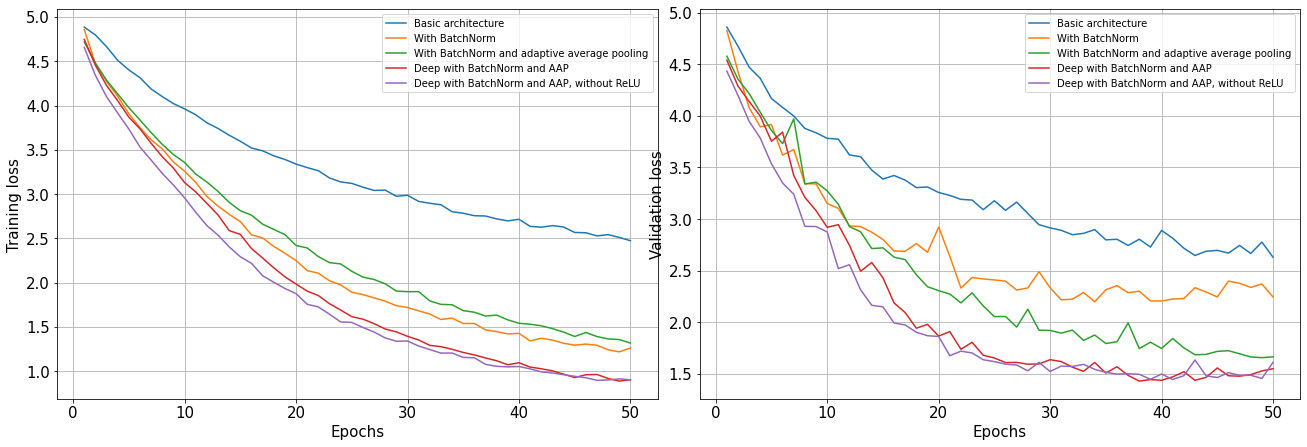

In [92]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

epochs = range(1,51)

plt.figure()
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
f.tight_layout()
fsize = 15

ax1.plot(epochs, train_loss_list_scratch, label='Basic architecture')
ax1.plot(epochs, train_loss_list_batch_norm, label='With BatchNorm')
ax1.plot(epochs, train_loss_list_batch_norm_aap, label='With BatchNorm and adaptive average pooling')
ax1.plot(epochs, train_loss_list_batch_norm_aap_deep, label='Deep with BatchNorm and AAP')
ax1.plot(epochs, train_loss_list_batch_norm_aap_deep_no_relu, label='Deep with BatchNorm and AAP, without ReLU')
ax1.set_xlabel('Epochs', fontsize = fsize)
ax1.set_ylabel('Training loss', fontsize = fsize)
ax1.legend()
ax1.tick_params(labelsize = fsize)
ax1.grid()
ax1.legend(fontsize = 10)

ax2.plot(epochs, valid_loss_list_scratch, label='Basic architecture')
ax2.plot(epochs, valid_loss_batch_norm, label='With BatchNorm')
ax2.plot(epochs, valid_loss_batch_norm_aap, label='With BatchNorm and adaptive average pooling')
ax2.plot(epochs, valid_loss_batch_norm_aap_deep, label='Deep with BatchNorm and AAP')
ax2.plot(epochs, valid_loss_batch_norm_aap_deep_no_relu, label='Deep with BatchNorm and AAP, without ReLU')
ax2.set_xlabel('Epochs', fontsize = fsize)
ax2.set_ylabel('Validation loss', fontsize = fsize)
ax2.legend()
ax2.tick_params(labelsize = fsize)
ax2.grid()
ax2.legend(fontsize = 10)

plt.savefig('Network_architectures.png', bbox_inches='tight', orientation='landscape', dpi=300)

<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

In this step we will employ transfer learning to create a CNN that can identify dog breed from images and will also reuse the data loaders that were created earlier.

In [20]:
# define loaders_scratch
loaders_scratch = {'train': train_dataloader,
                   'valid': valid_dataloader,
                   'test': test_dataloader}

## Specify data loaders
loaders_transfer = loaders_scratch

In [32]:
from torchvision import datasets, transforms, models

# define loaders_scratch again

data_dir = 'dogImages'

train_transforms = transforms.Compose([transforms.Resize(size=258),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomRotation(10),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

validTest_transforms = transforms.Compose([transforms.Resize(size=258),
                                           transforms.CenterCrop(224),
                                           transforms.ToTensor(),
                                           transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transforms)
valid_dataset = datasets.ImageFolder(os.path.join(data_dir, 'valid'), transform=validTest_transforms)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=validTest_transforms)

trainLoader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=128,
                                          shuffle=True,
                                          num_workers=0)

validLoader = torch.utils.data.DataLoader(valid_dataset,
                                          batch_size=128,
                                          shuffle=True,
                                          num_workers=0)

testLoader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=16,
                                          shuffle=False,
                                          num_workers=0)

# define loaders_transfer
loaders_transfer = {'train': trainLoader,
                    'valid': validLoader,
                    'test': testLoader}

### Model Architecture

We will now use transfer learning to create a CNN to classify dog breed. We save the initialized model as the variable `model_transfer`.

In [34]:
import torchvision.models as models
import torch.nn as nn

# check if CUDA is available
use_cuda = torch.cuda.is_available()

## Specify model architecture 
model_transfer = models.vgg16(pretrained=True)


# Freeze parameters of the model to avoid brackpropagation during training
for param in model_transfer.parameters():
    param.requires_grad = False
    
    
# Define dog breed classifier part of model_transfer
classifier = nn.Sequential(nn.Linear(25088, 4096),
                           nn.ReLU(),
                           nn.Dropout(0.5),
                           nn.Linear(4096, 512),
                           nn.ReLU(),
                           nn.Dropout(0.5),
                           nn.Linear(512, num_classes))

# Replace the original classifier with the dog breed classifier from above
model_transfer.classifier = classifier
    

if use_cuda:
    model_transfer = model_transfer.cuda()

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 


1. We load the pretrained weights of `vgg16` as the transfer model since it has performed well on image classification tasks (e.g. ImageNet challenge). It has also been trained on dog images, among other things, thus containing high level feature information in its convolutional layers. The feature extractor of this model would be then useful for classification.


2. We then replace the classifier component with our own dog breed classifier. Our classifier is modeled with 3 fully connected layers, 3 dropout layers to reduce the number of parameters and then 2 ReLU activation functions. By `num_classes` in the last layer we specify 133 output nodes that in turn correspond to the number of classes (dog breeds).

3. We finally disable `requires_grad` for all parameters thus not updating at backpropagation


### Specify Loss Function and Optimizer


In [35]:
from torch.optim import lr_scheduler

# Set the loss and the optimization function
criterion_transfer = nn.CrossEntropyLoss()

# train own classifier -> model_transfer.classifier.parameters()
optimizer_transfer = optim.Adam(model_transfer.classifier.parameters(), lr=0.001)

### Train, Validate and Test the Model



In [ ]:
if use_cuda:
    model_transfer = model_transfer.cuda()
    

# train the model
model_transfer, train_loss_list_transfer, valid_loss_list_transfer = train(
    25, 
    loaders_transfer,
    model_transfer,
    optimizer_transfer, 
    criterion_transfer, 
    use_cuda, 
    'model_transfer.pt')


# load the model that got the best validation accuracy 
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

# test the model
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Epoch: 1 	Training Loss: 0.000699 	Validation Loss: 0.003634
Validation loss decreased (inf --> 0.003634). Saving model...
Epoch: 2 	Training Loss: 0.000443 	Validation Loss: 0.001799
Validation loss decreased (0.003634 --> 0.001799). Saving model...
Epoch: 3 	Training Loss: 0.000315 	Validation Loss: 0.001379
Validation loss decreased (0.001799 --> 0.001379). Saving model...
Epoch: 4 	Training Loss: 0.000261 	Validation Loss: 0.001089
Validation loss decreased (0.001379 --> 0.001089). Saving model...
Epoch: 5 	Training Loss: 0.000221 	Validation Loss: 0.001003
Validation loss decreased (0.001089 --> 0.001003). Saving model...
Epoch: 6 	Training Loss: 0.000202 	Validation Loss: 0.000929
Validation loss decreased (0.001003 --> 0.000929). Saving model...
Epoch: 7 	Training Loss: 0.000189 	Validation Loss: 0.000921
Validation loss decreased (0.000929 --> 0.000921). Saving model...
Epoch: 8 	Training Loss: 0.000173 	Validation Loss: 0.000914
Validation loss decreased (0.000921 --> 0.000914

### Predict Dog Breed with the Model

Now we put together a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by the model.  

In [54]:
from PIL import Image

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in train_dataset.classes]

model_transfer.load_state_dict(torch.load('model_transfer.pt'))

def predict_dog_breed_with_transfer_learning_model(img_path, model_transfer, use_cuda, class_names):
    """
    It loads the image and returns the predicted breed
    
    """
        
    # We use the previous function to preprocess (tranform) and normalise 
    # the incoming image
    tensor = image_to_tensor(img_path)

    # Prepare a batch to be passed through the network
    batch_t = torch.unsqueeze(tensor, 0)
    
    # Move it to GPU if available
    if use_cuda:
        batch_t = batch_t.cuda()
    
    #############
    # Inference #
    #############
    
    # Turn on evaluation mode
    model_transfer.eval()
    
    # Get predicted category for image
    with torch.no_grad():
        # Carry out inference
        out = model_transfer(batch_t)
        # Return the *index* of the predicted class for that image
        result = torch.argmax(out).item()
        
    # Turn off evaluation mode
    model_transfer.train()
    
    # Use predicted result to get dog breed
    dog_breed = class_names[result]
    
    return dog_breed

---
<a id='step5'></a>
## Step 5: Write the Algorithm

Now we write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

Since `face_detector` and `human_detector` functions were developed earlier to detect humans and dogs in images, we are going to use them at this step too. We are also going to use the CNN from Step 4 to predict the dog breed.  

### A simple algorithm

In [62]:
def run_app(img_path):
    """
    It handles cases for a human face, dog, and neither.
    """
    
    title_message = 'Oops. You are neither a human nor a dog!'
    
    if face_detector(img_path):
        dog_breed = predict_dog_breed_with_transfer_learning_model(img_path, model_transfer, use_cuda, class_names)
        title_message = 'Hello human! You look like a ...\n' + dog_breed + '!'
        
    if VGG16_dog_detector(img_path):
        dog_breed = predict_dog_breed_with_transfer_learning_model(img_path, model_transfer, use_cuda, class_names)
        title_message = 'Hello dog! Your predicted breed is ...\n' + dog_breed + '!'    
    
    plt.figure()
    plt.imshow(Image.open(img_path))
    plt.title(title_message)
    plt.show()  

---
<a id='step6'></a>
## Step 6: Test the algorithm

Let's take it for a spin!  What kind of dog does the algorithm think that _I_ look like?  Here I collected some sample images of my friends and of my friends' pets and feed them through the algorithm. .



We test the algorithm on several sample images that contain, dogs, animals other than dogs and humans. The performance is better than expected. However, we used a model based on transfer learning. The following could help: 

1. The limited amount of images per dog breed category made the data set challenging. We need a much larger dataset with more number of samples per category.

2. The data augmentation step is definitely an area for further research. 

3. We tried different variants of our base light VGG-like architecuture. This is definitely an area of improvement.

In [56]:
more_humans = np.array(glob("humans/*"))
more_animals = np.array(glob("animals/*"))

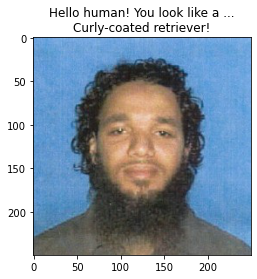

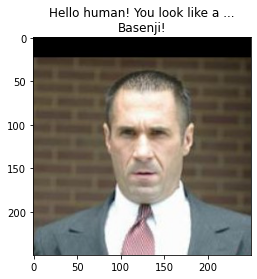

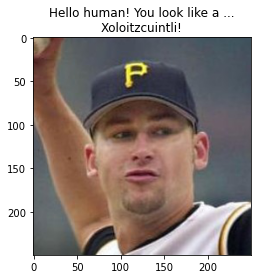

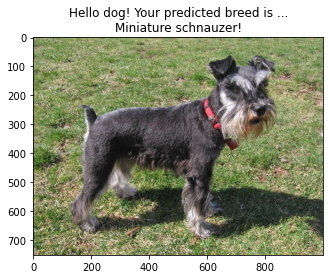

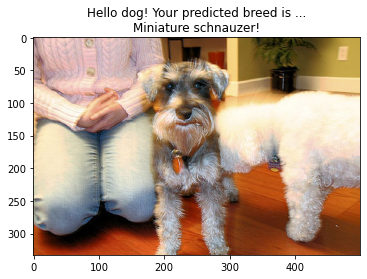

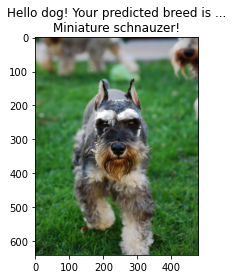

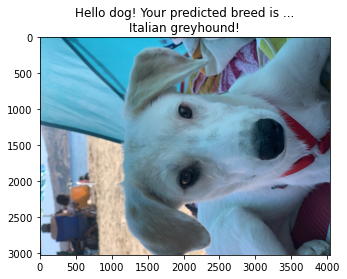

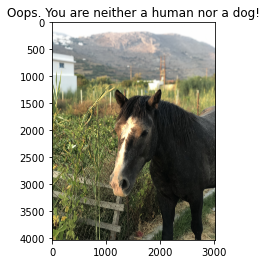

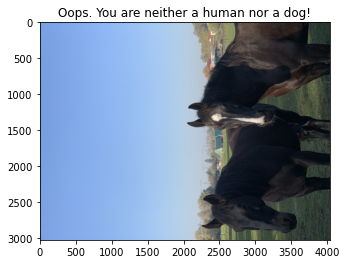

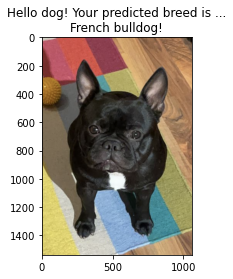

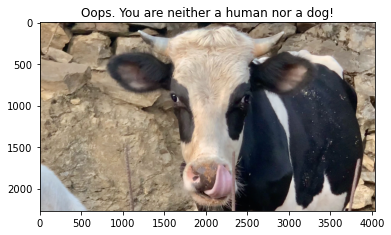

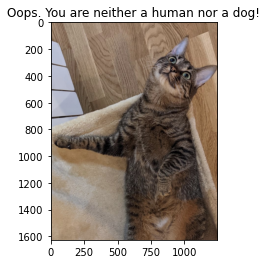

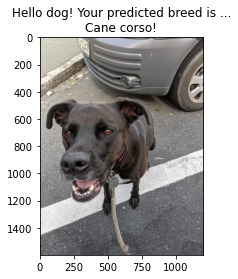

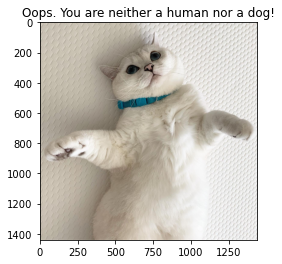

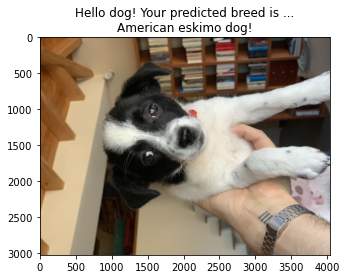

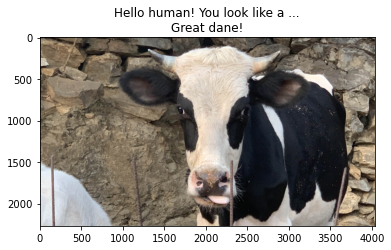

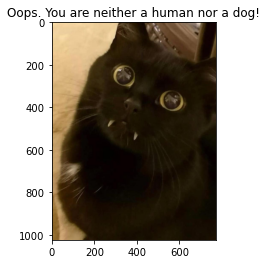

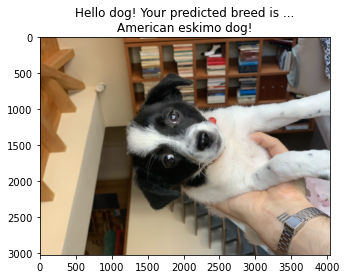

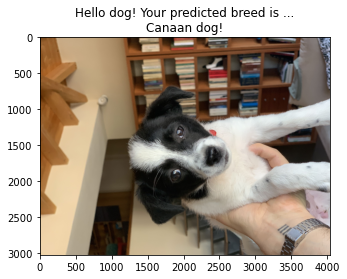

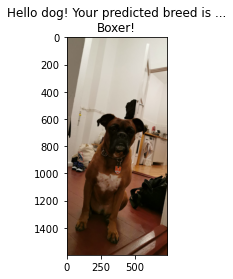

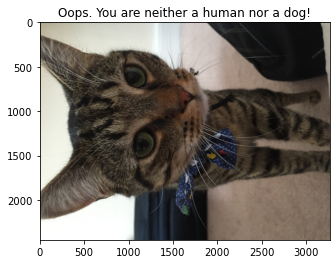

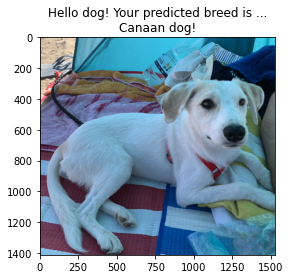

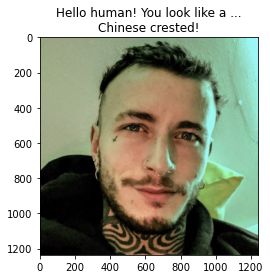

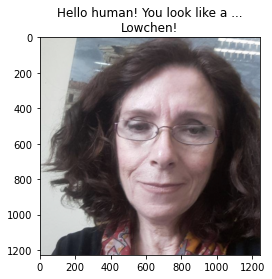

In [61]:
# run app
for file in np.hstack((human_files[:3], dog_files[:3], more_animals, more_humans)):
    run_app(file)